In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pydicom import dcmread
import cv2
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.collections import PolyCollection
import matplotlib.path as mpltPath
%matplotlib inline
from zipfile import ZipFile
from scipy import interpolate as sciinterp
from meshpy.triangle import MeshInfo, build

from getfem import *

import sys
import os
wd = os.getcwd()

In [2]:
#dicom file info

SESSION = 'BoyceTest01'
path_to_download = 'C:/path/to/session/' + SESSION + '/SESSIONS/Boyce^Magma Flow/ACQUISITIONS'

path_mag = 'BEAT_FQ2_n2o10_venc10_2d_5';
path_vel = ['BEAT_FQ2_n2o10_venc10_2d_5_P', 'BEAT_FQ2_n2o10_venc10_2d_5_P_0'];

df = pd.read_excel('Experiments list.xlsx')

In [3]:
dat = df.loc[df.Session == SESSION].loc[df.String==path_mag]
dat

,Date,Time,Session,String,Particle vol %,Gas vol %,Liquid viscosity (St),Height (cm),Slice,Vel_along,Vel_across,Vel_vert,expid,Start frame,End frame,x_shift,y_shift,t_shift,Observations,Unnamed: 19
11,2021-04-30,10:31:00,BoyceTest01,BEAT_FQ2_n2o10_venc10_2d_5,0,5,5,7.0,Along,10.0,NaN,10.0,par0_gas5_liq5_H7,4.0,9.0,17.0,0.7,0.2,In fitting looks like consistency from BLL is ...,NaN


In [4]:
#dicom file info

rot = 'Along' in dat.Slice.values
velocity = 0
vel_stretch = []
vel_dir = []
vel_titles = {'Vel_along':'Along-channel', 'Vel_across':'Across-channel', 'Vel_vert':'Vertical'}
for col in ['Vel_along','Vel_across','Vel_vert']:
    if not np.isnan(dat[col].values[0]):
        velocity += 1 #number of velocity encodings
        vel_stretch = np.append(vel_stretch,dat[col].values[0]/100) # convert to m/s
        vel_dir = np.append(vel_dir,vel_titles[col])
frames = np.arange(int(dat['Start frame'].values[0]), int(dat['End frame'].values[0])-2)
flow_front = False
thresh = 0.004 # minimum magnitude of signal intensity
gateframe = int(dat['Start frame'].values[0]) + 1 # frame of gate removal (used to calculate time from release)

# Experiment parameters
H = dat['Height (cm)'].values[0]/100 # convert to cm
phi_gas = dat['Gas vol %'].values[0]/100 # convert to fraction
phi_solid = dat['Particle vol %'].values[0]/100
eta_liq = dat['Liquid viscosity (St)'].values[0]*1000/975 # convert to Pas
mu = eta_liq*2.5
rhoh = 975*(1-phi_gas)
rho0 = 975
g = 9.81

tau_y = 1
n = 1.0
K = 10
eta_max = 1000

# Image processing parameters
windowSize = 3 # size for initial smoothing kernel
sigma_x = 10 # gaussian smoothing in x-direction
sigma_y = 0.05 # gaussian smoothing in y-direction
thresh2 = 130 # rethreshold after smoothing (0,255)

x_shift = dat['x_shift'].values[0]/100 # position of MRI image left edge with respect to channel back (cm), convert to m
y_shift = dat['y_shift'].values[0]/100 # position of MRI image bottom edge with respect to channel bottom (cm), convert to m
t_shift = dat['t_shift'].values[0] # time before gateframe when gate is actually removed (s)

# location to save figures
direct = 'C:/path/to/output/' + dat['expid'].values[0]

# temporarily unzip files to local directory
try: 
    os.remove('temp')
except: 
    print('Nothing to delete')

try: 
    os.mkdir('temp')
except: 
    print('Already exists')
comp_mag = path_to_download + '/' + path_mag + '/Files/' + [f.split('.zip')[0] for f in os.listdir(path_to_download + '/' + path_mag + '/Files/') if ('.zip' in f)][0]

with ZipFile(comp_mag + '.zip', 'r') as zf:
    zf.extractall(wd + '/temp/mag')


for i in np.arange(velocity):
    comp_vel = path_to_download + '/' + path_vel[i] + '/Files/' + [f.split('.zip')[0] for f in os.listdir(path_to_download + '/' + path_vel[i] + '/Files/') if ('.zip' in f)][0]

    with ZipFile(comp_vel + '.zip', 'r') as zf:
        zf.extractall(wd + '/temp/vel' + str(i))


Nothing to delete
Already exists


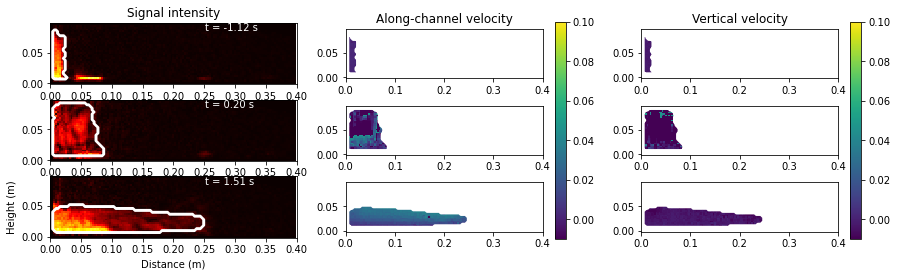

In [5]:
# visualize data
ds = dcmread('temp/mag/' + os.listdir('temp/mag')[0] + '/' + os.listdir('temp/mag/' + os.listdir('temp/mag')[0])[gateframe])
gatetime = ds.AcquisitionTime

if rot:
    mags = np.zeros((frames.size,ds.pixel_array.shape[1], ds.pixel_array.shape[0]))
else: 
    mags = np.zeros((frames.size,ds.pixel_array.shape[0], ds.pixel_array.shape[1]))
masks = np.zeros_like(mags)

if velocity>0: 
    if rot: 
        vels = np.zeros((frames.size,ds.pixel_array.shape[1], ds.pixel_array.shape[0],velocity))
    else:
        vels = np.zeros((frames.size,ds.pixel_array.shape[0], ds.pixel_array.shape[1],velocity))

#us = np.zeros((frames.size,u.shape[2],u.shape[1]))
ts = np.zeros(frames.size)

ncols = 1+velocity
fig2,ax2 = plt.subplots(ncols=ncols,nrows=len(frames),figsize=(15,4))

x_front = np.zeros_like(frames, dtype=float)
t_front = np.zeros_like(frames, dtype=float)

im1 = []

for i,j in enumerate(frames):
    ds = dcmread('temp/mag/' + os.listdir('temp/mag')[0] + '/' + os.listdir('temp/mag/' + os.listdir('temp/mag')[0])[j])
    dt = float(ds.AcquisitionTime) - float(gatetime)
    mag = ds.pixel_array.astype(float)
    mag = mag/(2**ds.BitsStored)
    if rot:
        mag = mag.transpose()
    mag = np.flipud(mag)
    height = mag.shape[0]
    
    dx = 0.4/mag.shape[1]
    x_scale = np.arange(mag.shape[1])*dx
    y_scale = np.arange(mag.shape[0])*dx
    
    mags[i,:,:] = mag
    
    # Read image
    im_mag = np.zeros_like(mag).astype(np.uint8)
    im_mag[mag<thresh] = 255
 
    # Remove low signal regions inside flow
    im_floodfill = im_mag.copy()
    cv2.floodFill(im_floodfill, None, (0, 0), 0)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = im_mag & im_floodfill_inv

    # Remove high signal regions outside flow
    im_floodfill = im_out.copy()
    cv2.floodFill(im_floodfill, None, (5, 10), 255) # select interior point
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = ~im_out & (~im_floodfill_inv)
    
    # Smooth outline
    
    im_blur = cv2.blur(im_out,(windowSize,windowSize), borderType=0)
    
    if dt>=0:
        im_blur = cv2.GaussianBlur(im_blur,(int(2*np.ceil(2*sigma_x)+1),int(2*np.ceil(2*sigma_y)+1)),sigma_x,sigma_y,
                              borderType=0) 

    # Rethreshold
    mask = im_blur>thresh2
    mask[y_scale<y_shift,:] = False
    #mask = np.flipud(mask)
    ax2[i,0].pcolormesh(x_scale, y_scale, mask, shading='auto')
    im0 = ax2[i,0].pcolormesh(x_scale, y_scale, mag, cmap=plt.cm.hot, shading='auto', vmin=0, vmax=0.06)
    cs = ax2[i,0].contour(x_scale, y_scale, mask, levels=1,colors='w',linewidths=2)

    # Get flow outline
    p = cs.collections[0].get_paths()
    c_x = []
    c_y = []
    for p_i in p:
        v = p_i.vertices
        c_x = np.append(c_x, v[:,0])
        c_y = np.append(c_y, v[:,1])
        
    t_front[i] = dt
    x_front[i] = np.max(c_x)
        
    masks[i,:,:] = mask
        
    ax2[0,0].set_title('Signal intensity')
    ax2[i,0].annotate('t = ' + '{:.2f}'.format(dt+t_shift) + ' s',(0.63,0.87),xycoords='axes fraction',color='w')
    ax2[i,0].set_xlim([0,0.4])
    
    # Plot velocities
    for k in np.arange(velocity):
        ds = dcmread('temp/vel' + str(k) + '/' + os.listdir('temp/vel' + str(k))[0] + '/' + os.listdir(
            'temp/vel' + str(k) + '/'+ os.listdir('temp/vel' + str(k))[0])[j])
        vel = ds.pixel_array.astype(float)
        vel = -vel_stretch[k]*(vel-(2**(ds.BitsStored-1)))/(2**ds.BitsStored-1)
        if rot:
            vel = vel.transpose()
        vel = np.flipud(vel)
        
        vel_plot = vel.copy()
        vel_plot[~mask] = np.nan
        
        vels[i,:,:,k] = vel
        
        ax2[0,k+1].set_title(vel_dir[k] + ' velocity')
        im_temp = ax2[i,k+1].pcolormesh(x_scale, y_scale, vel_plot, cmap=plt.cm.viridis, shading='auto', vmin=-0.01, vmax=vel_stretch[k])
        if i == 0:
            im1 = np.append(im1,im_temp)
        ax2[i,k+1].plot(c_x,c_y,'w',linewidth=4)
        ax2[i,k+1].set_xlim([0,0.4])
        
        ts[i] = dt+t_shift
        
for k in np.arange(velocity):
    cbar = fig2.colorbar(im1[k], ax=ax2[:, k+1], aspect=20)

ax2[i,0].set_xlabel('Distance (m)')
ax2[i,0].set_ylabel('Height (m)')
for ax_col in ax2:
    for axi in ax_col:
        axi.set_aspect('equal')

fig2.savefig(direct + '_time_series.pdf',bbox_inches='tight');

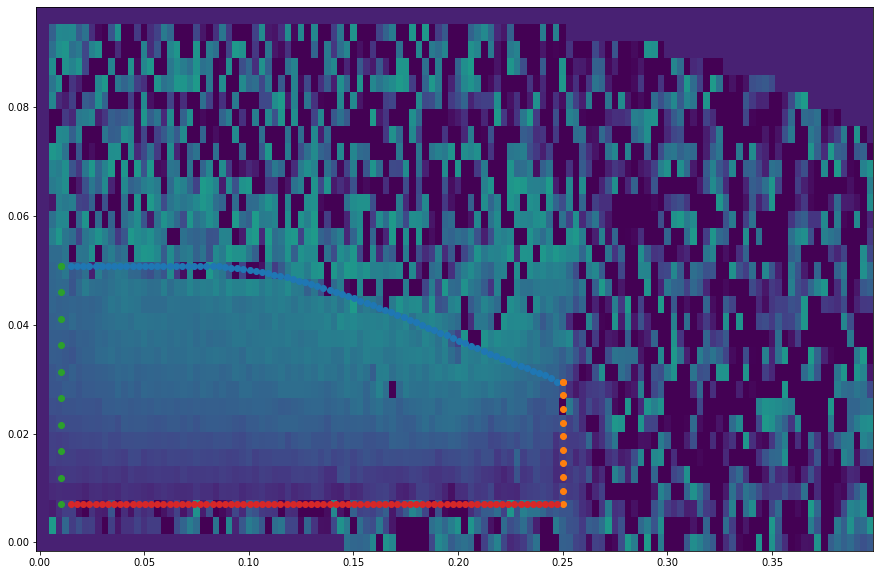

In [6]:
ind = (c_x>0.001) & (c_y>y_shift+0.02)
surf_x = np.append(np.append(np.max(c_x),c_x[ind]),0)
surf_y = np.append(np.append(0,c_y[ind]),np.max(c_y))
spl = sciinterp.UnivariateSpline(surf_x[::-1], surf_y[::-1],s=9)

top_x = np.linspace(0.015,np.max(c_x)-0.0025,80)
top_y = spl(top_x)
top_y[:np.argmax(spl(top_x))] = np.max(spl(c_x))
top_y[np.argmin(spl(top_x)):] = np.min(spl(c_x))
left_y = np.append(np.linspace(y_shift, np.max(spl(c_x)),10), np.max(spl(c_x)))
right_y = np.append(np.linspace(y_shift, spl(np.max(c_x)),10), spl(np.max(c_x)))[::-1]

ptsx = np.append(np.append(np.append(np.ones_like(left_y)*0.01,top_x),np.ones_like(right_y)*np.max(c_x)),top_x[::-1])
ptsy = np.append(np.append(np.append(left_y,top_y),right_y),np.ones_like(top_x)*y_shift)

fig,ax = plt.subplots(figsize=(15,10))

ax.pcolormesh(x_scale, y_scale, vels[-1,:,:,0], cmap=plt.cm.viridis, shading='auto', vmin=-0.01, vmax=vel_stretch[k],zorder=0)
ax.scatter(top_x,top_y)
ax.scatter(np.ones_like(right_y)*np.max(c_x),right_y)
ax.scatter(np.ones_like(left_y)*0.01,left_y)
ax.scatter(top_x,np.ones_like(top_x)*y_shift)

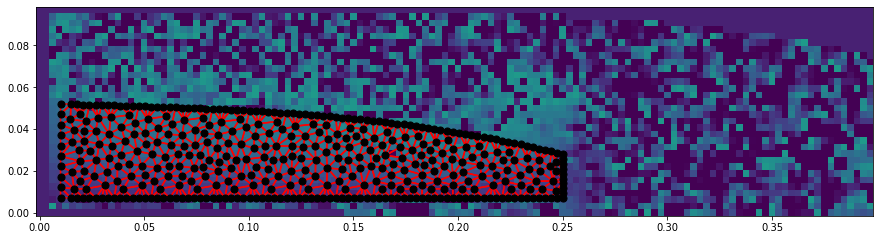

In [7]:
ind = (c_x>0.01) & (c_y>y_shift+0.02)
for i, (x_0, x_1) in enumerate(zip(c_x, c_x[1:])):
    if x_1>x_0:
        ind[i] = False
surf_x = np.append(np.append(np.max(c_x),c_x[ind]),0)
surf_y = np.append(np.append(0,c_y[ind]),np.max(c_y))
spl = sciinterp.UnivariateSpline(surf_x[::-1], surf_y[::-1],s=9)

top_x = np.linspace(0.015,np.max(c_x)-0.0025,80)
top_y = spl(top_x)
top_y[:np.argmax(spl(top_x))] = np.max(spl(top_x))
left_y = np.append(np.linspace(y_shift, np.max(spl(c_x)),10), np.max(spl(c_x)))
right_y = np.append(np.linspace(y_shift, spl(np.max(c_x)),10), spl(np.max(c_x)))[::-1]

ptsx = np.append(np.append(np.append(np.ones_like(left_y)*0.01,top_x),np.ones_like(right_y)*np.max(c_x)),top_x[::-1])
ptsy = np.append(np.append(np.append(left_y,top_y),right_y),np.ones_like(top_x)*y_shift)
fig,ax = plt.subplots(figsize=(15,10))
ax.pcolormesh(x_scale, y_scale, vels[-1,:,:,0], cmap=plt.cm.viridis, shading='auto', vmin=-0.01, vmax=vel_stretch[k],zorder=0)

mesh_info = MeshInfo()
mesh_info.set_points(list(zip(ptsx,ptsy)))
mesh_info.set_facets(list(zip(np.arange(len(ptsx)),np.roll(np.arange(len(ptsy)),-1))))
mesh = build(mesh_info, max_volume=0.000025)
#print("Mesh Points:")
for i, p in enumerate(mesh.points):
    #print(p)
    ax.scatter(p[0],p[1],50,'k',zorder=2)
#print("Point numbers in tetrahedra:")
for i, t in enumerate(mesh.elements):
    pts = np.array([mesh.points[t[0]], mesh.points[t[1]], mesh.points[t[2]], mesh.points[t[0]]])
    plt.plot(pts[:,0], pts[:,1], 'r',zorder=1);
ax.set_aspect('equal')


In [8]:
import getfem as gf

gfmesh = gf.Mesh('empty', 2)

#for pt in mesh.points:
#    gfmesh.add_point(pt)
for e in mesh.elements:
    pts = np.array([mesh.points[e[0]], mesh.points[e[1]], mesh.points[e[2]]]).transpose()
    gfmesh.add_convex(gf.GeoTrans('GT_PK(2,1)'),pts)
    
fb_right = gfmesh.outer_faces_with_direction([ 1., 0.], 0.1) # outward vector in [x,y], tolerance angle theta (rad)
fb_left = gfmesh.outer_faces_with_direction([-1., 0.], 0.1)
fb_top = gfmesh.outer_faces_with_direction([0.,  1.], 1)
fb_bot = gfmesh.outer_faces_with_direction([0., -1.], 0.1)
#fb_topleft = mesh.outer_faces_in_box([-0.01, L_y-L_y/(2*ny)], [L_x/nx*1.5, 1.01]) # top left

bounds = [fb_right, fb_left, fb_top, fb_bot]
RIGHT_BOUND=1; LEFT_BOUND=2; TOP_BOUND=3; BOTTOM_BOUND=4;

for i,bound in enumerate(bounds): 
    gfmesh.set_region(i+1, bound)

In [12]:
# Define variable fields and approximations
# velocity
mfu = gf.MeshFem(gfmesh, 2) # vector field
mfu.set_fem(Fem('FEM_PK(2,2)')) # continuous piecewise linear
#mfu.set_fem(Fem('FEM_PK_WITH_CUBIC_BUBBLE(2,1)')) # continuous piecewise quadratic
# pressure
mfp = gf.MeshFem(gfmesh, 1) # scalar field
mfp.set_fem(Fem('FEM_PK(2,1)')) # continuous piecewise linear

mim = gf.MeshIm(gfmesh, 4)

# use model blocks to assemble problem - can alternatively be done manually
md=gf.Model('real'); # real vs complex system
md.add_fem_variable('u', mfu)
md.add_fem_variable('p', mfp)

D = mfp.basic_dof_nodes()
ones = np.ones(D.shape[1])
x = D[0,:]
y = D[0,:]

# add coefficients
#md.add_initialized_data('mu', [mu])
md.add_initialized_data('lambda', [0])
md.add_initialized_data('g', [0,g])
md.add_initialized_fem_data('rho',mfp,[(rhoh-rho0)/spl(x)*y + rho0])

mu_exp = 'min(' + str(eta_max) + ', ' + str(tau_y) + '/t + ' + str(K) + '*pow(t, ' + str(n-1) + '))'
gf.asm_define_function('mu', 1, mu_exp)

md.add_nonlinear_term(mim, "mu(Norm(Grad_u - Grad_u.*Id(2)))*((Grad_u + Grad_u'):Grad_Test_u) + rho*(g.Test_u)")
md.add_linear_incompressibility_brick(mim, 'u', 'p') 

# Apply BCs
spl2d_u = sciinterp.RectBivariateSpline(x_scale,y_scale,vels[-1,:,:,0].transpose(),kx=3,ky=3,s=1.6e4)
u_dat_smooth = spl2d_u.ev(D[0,:],D[1,:])
u_dat_smooth[u_dat_smooth>np.max(vels[-1,:,:,0])] = np.max(vels[-1,:,:,0])

spl2d_v = sciinterp.RectBivariateSpline(x_scale,y_scale,vels[-1,:,:,1].transpose(),kx=3,ky=3,s=1.6e4)
v_dat_smooth = spl2d_v.ev(D[0,:],D[1,:])
v_dat_smooth[v_dat_smooth>np.max(vels[-1,:,:,1])] = np.max(vels[-1,:,:1])

md.add_initialized_fem_data('leftdata', mfp, [u_dat_smooth,v_dat_smooth])
md.add_initialized_fem_data('botdata', mfp, [0*ones,0*ones])

md.add_Dirichlet_condition_with_multipliers(mim, 'u', 0, LEFT_BOUND, dataname='leftdata')
md.add_Dirichlet_condition_with_multipliers(mim, 'u', 0, BOTTOM_BOUND, dataname='botdata')

md.add_initialized_fem_data('topdata', mfp, [[0*ones, 0*ones],
                                             [0*ones, 0*ones]])
md.add_normal_source_term_brick(mim, 'u', 'topdata', TOP_BOUND);

if flow_front: 
    md.add_initialized_fem_data('rightdata', mfp, [[0*ones, 0*ones],
                                             [0*ones, 0*ones]])
    md.add_normal_source_term_brick(mim, 'u', 'rightdata', RIGHT_BOUND);
else: 
    md.add_initialized_fem_data('rightdata',mfp, [u_dat_smooth,v_dat_smooth])
    md.add_Dirichlet_condition_with_multipliers(mim, 'u', 0, RIGHT_BOUND, dataname='rightdata')

In [13]:
# solve all in one
md.solve('max_res', 1E-9, 'max_iter', 100, 'very_noisy'); # Newton iteration for nonlinearity

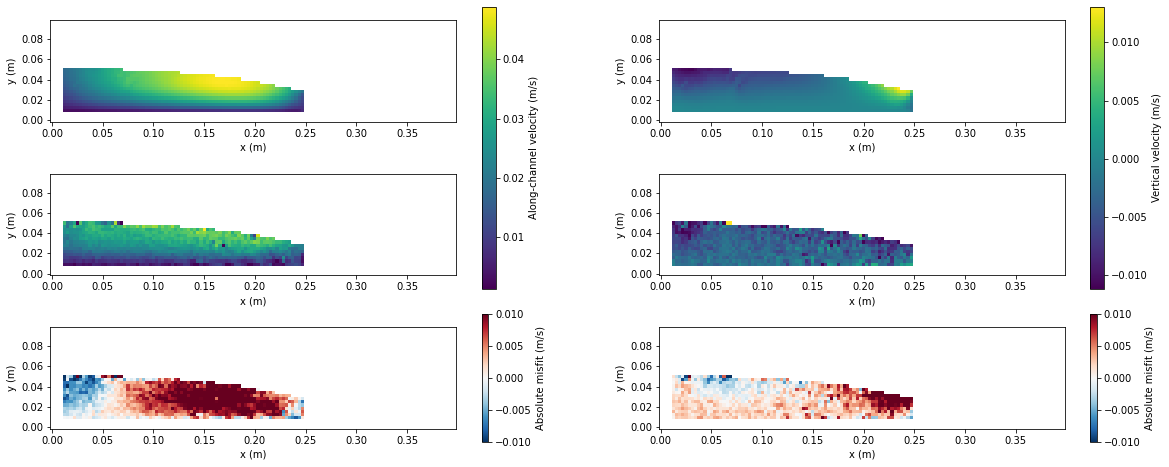

In [14]:
# Retrieve variables
u = md.variable('u')
P = md.variable('p')

mfu.export_to_vtk('test_u.vtk', u)
mfp.export_to_vtk('test_p.vtk', P)

X, Y = np.meshgrid(x_scale,y_scale)

path = mpltPath.Path(np.array([ptsx,ptsy]).transpose())
inside = path.contains_points(np.array([X.flatten(),Y.flatten()]).transpose())
[ui,vi] = compute(mfu,u,'interpolate on',[X.flatten()[inside],Y.flatten()[inside]])

u_sol = np.full_like(X.flatten(), np.nan)
u_sol[inside] = ui
u_sol = np.reshape(u_sol,X.shape)

v_sol = np.full_like(X.flatten(), np.nan)
v_sol[inside] = vi
v_sol = np.reshape(v_sol,X.shape)

u_dat = vels[-1,:,:,0].flatten()
u_dat[~inside] = np.nan
u_dat = np.reshape(u_dat,X.shape)

v_dat = vels[-1,:,:,1].flatten()
v_dat[~inside] = np.nan
v_dat = np.reshape(v_dat,X.shape)

fig,ax = plt.subplots(figsize=(20,8),nrows=3,ncols=2)
ax[0,0].pcolormesh(x_scale, y_scale, u_sol, cmap=plt.cm.viridis, shading='auto', 
                   vmin=np.min([np.nanmin(u_dat_smooth),np.nanmin(u_sol)]), vmax=np.max([np.nanmax(u_dat_smooth),np.nanmax(u_sol)]))
c0 = ax[1,0].pcolormesh(x_scale, y_scale, u_dat, cmap=plt.cm.viridis, shading='auto', 
                        vmin=np.min([np.nanmin(u_dat_smooth),np.nanmin(u_sol)]), vmax=np.max([np.nanmax(u_dat_smooth),np.nanmax(u_sol)]))
c1 = ax[2,0].pcolormesh(x_scale, y_scale, u_sol-u_dat, cmap='RdBu_r', shading='auto', 
                        vmin=-0.01, vmax=0.01)
plt.colorbar(c0, ax=ax[:2,0], label='Along-channel velocity (m/s)')
plt.colorbar(c1, ax=ax[2,0], label='Absolute misfit (m/s)')

ax[0,1].pcolormesh(x_scale, y_scale, v_sol, cmap=plt.cm.viridis, shading='auto', 
                   vmin=np.min([np.nanmin(v_dat_smooth),np.nanmin(v_sol)]), vmax=np.max([np.nanmax(v_dat_smooth),np.nanmax(v_sol)]))
c2 = ax[1,1].pcolormesh(x_scale, y_scale, v_dat, cmap=plt.cm.viridis, shading='auto', 
                        vmin=np.min([np.nanmin(v_dat_smooth),np.nanmin(v_sol)]), vmax=np.max([np.nanmax(v_dat_smooth),np.nanmax(v_sol)]))
c3 = ax[2,1].pcolormesh(x_scale, y_scale, v_sol-v_dat, cmap='RdBu_r', shading='auto', 
                        vmin=-0.01, vmax=0.01)
plt.colorbar(c2, ax=ax[:2,1], label='Vertical velocity (m/s)')
plt.colorbar(c3, ax=ax[2,1], label='Absolute misfit (m/s)')

for ax_col in ax:
    for axi in ax_col:
        axi.set_aspect('equal')
        axi.set_xlabel('x (m)')
        axi.set_ylabel('y (m)')

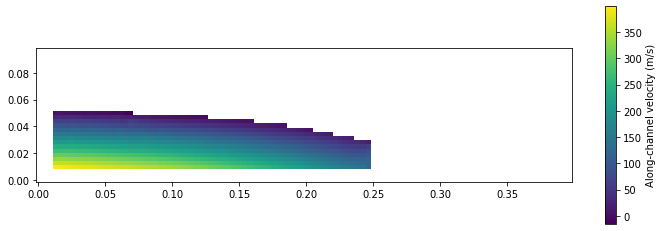

In [16]:
pi = compute(mfp,P,'interpolate on',[X.flatten()[inside],Y.flatten()[inside]])
p_sol = np.full_like(X.flatten(), np.nan)
p_sol[inside] = pi
p_sol = np.reshape(p_sol,X.shape)

fig,ax = plt.subplots(figsize=(12,4))
c0 = ax.pcolormesh(x_scale, y_scale, p_sol, cmap=plt.cm.viridis, shading='auto')
plt.colorbar(c0, label='Along-channel velocity (m/s)')
ax.set_aspect('equal')